In [1]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 458331, done.
remote: Counting objects: 100% (38790/38790), done.
remote: Compressing objects: 100% (1796/1796), done.
remote: Total 458331 (delta 36985), reused 38687 (delta 36936), pack-reused 419541
Receiving objects: 100% (458331/458331), 900.00 MiB | 25.57 MiB/s, done.
Resolving deltas: 100% (426073/426073), done.
fatal: not a git repository (or any of the parent directories): .git


In [2]:
import zipfile
import torch
import torch.nn as nn
import os
import cv2 as cv
import torch.optim as optim
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import timeit
import pickle
import matplotlib.pyplot as plt
import torchvision.models as models
# from google.colab.patches import cv2_imshow

import random
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from xml.etree import ElementTree as et
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import sys

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
path_to_images = "/validare" # calea catre imaginile de test
solution_path_root = "/" # aici se vor crea fisierele de output

path_to_model = "/model_alexnet_task1.pth"

path_to_model_barney = "/model_barney_alexnet.pth"
path_to_model_betty = "/model_betty_alexnet.pth"
path_to_model_fred = "/model_fred_alexnet.pth"

path_to_model_wilma = "/model_wilma_alexnet.pth"
path_to_model_unknown = "/model_unknown_alexnet.pth"
path_to_model_bonus = "/model_bonus_epoch_4.pth"

## Fisiere pt evaluare
dir_save_files = "/save_files" # aici se salveaza imaginile de output

ground_truth_path_root = "/validare/"
path_annotations = "/validare/task1_gt_validare.txt"


In [ ]:
class_names = ["barney", "betty", "fred", "wilma", "unknown"]
dim_window = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#@title Crearea folderelor de output
os.makedirs(dir_save_files, exist_ok=True)

task1_path = os.path.join(solution_path_root, 'task1')
os.makedirs(task1_path, exist_ok=True)

# Creează directorul pentru Task 2
task2_path = os.path.join(solution_path_root, 'task2')
os.makedirs(task2_path, exist_ok=True)

# Creează directorul pentru Bonus
bonus_path = os.path.join(solution_path_root, 'bonus')
os.makedirs(bonus_path, exist_ok=True)

# Creează directorul pentru Task 1 în Bonus
bonus_task1_path = os.path.join(bonus_path, 'task1')
os.makedirs(bonus_task1_path, exist_ok=True)

# Creează directorul pentru Task 2 în Bonus
bonus_task2_path = os.path.join(bonus_path, 'task2')
os.makedirs(bonus_task2_path, exist_ok=True)


In [ ]:
#@title Incarcarea modelelor
model = models.alexnet(pretrained=False)
model.classifier[6] = nn.Linear(in_features=4096, out_features=2)
model.load_state_dict(torch.load(path_to_model))
model.eval()

model_barney = models.alexnet(pretrained=False)
model_barney.classifier[6] = nn.Linear(in_features=4096, out_features=2)
model_barney.load_state_dict(torch.load(path_to_model_barney))
model_barney.eval()

model_betty = models.alexnet(pretrained=False)
model_betty.classifier[6] = nn.Linear(in_features=4096, out_features=2)
model_betty.load_state_dict(torch.load(path_to_model_betty))
model_betty.eval()

model_fred = models.alexnet(pretrained=False)
model_fred.classifier[6] = nn.Linear(in_features=4096, out_features=2)
model_fred.load_state_dict(torch.load(path_to_model_fred))
model_fred.eval()

model_wilma = models.alexnet(pretrained=False)
model_wilma.classifier[6] = nn.Linear(in_features=4096, out_features=2)
model_wilma.load_state_dict(torch.load(path_to_model_wilma))
model_wilma.eval()

model_unknown = models.alexnet(pretrained=False)
model_unknown.classifier[6] = nn.Linear(in_features=4096, out_features=2)
model_unknown.load_state_dict(torch.load(path_to_model_unknown))
model_unknown.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
model.to("cuda")
model_barney.to("cuda")
model_betty.to("cuda")
model_fred.to("cuda")
model_wilma.to("cuda")
model_unknown.to("cuda")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#@title Intersection over union
def intersection_over_union(bbox_a, bbox_b):
    x_a = max(bbox_a[0], bbox_b[0])
    y_a = max(bbox_a[1], bbox_b[1])
    x_b = min(bbox_a[2], bbox_b[2])
    y_b = min(bbox_a[3], bbox_b[3])

    inter_area = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)

    box_a_area = (bbox_a[2] - bbox_a[0] + 1) * (bbox_a[3] - bbox_a[1] + 1)
    box_b_area = (bbox_b[2] - bbox_b[0] + 1) * (bbox_b[3] - bbox_b[1] + 1)

    iou = inter_area / float(box_a_area + box_b_area - inter_area)

    return iou

In [ ]:
#@title Non maximal suppression
def non_maximal_suppression(image_detections, image_scores, image_size, image_names):
    """
    Detectiile cu scor mare suprima detectiile ce se suprapun cu acestea dar au scor mai mic.
    Detectiile se pot suprapune partial, dar centrul unei detectii nu poate
    fi in interiorul celeilalte detectii.
    :param image_detections:  numpy array de dimensiune NX4, unde N este numarul de detectii.
    :param image_scores: numpy array de dimensiune N
    :param image_size: tuplu, dimensiunea imaginii
    :return: image_detections si image_scores care sunt maximale.
    """

    # xmin, ymin, xmax, ymax
    x_out_of_bounds = np.where(image_detections[:, 2] > image_size[1])[0]
    y_out_of_bounds = np.where(image_detections[:, 3] > image_size[0])[0]
    print(x_out_of_bounds, y_out_of_bounds)
    image_detections[x_out_of_bounds, 2] = image_size[1]
    image_detections[y_out_of_bounds, 3] = image_size[0]
    sorted_indices = np.flipud(np.argsort(image_scores))
    sorted_image_detections = image_detections[sorted_indices]
    sorted_scores = image_scores[sorted_indices]
    sorted_names = image_names[sorted_indices]

    is_maximal = np.ones(len(image_detections)).astype(bool)
    iou_threshold = 0.3
    for i in range(len(sorted_image_detections) - 1):
        if is_maximal[i] == True:  # don't change to 'is True' because is a numpy True and is not a python True :)
            for j in range(i + 1, len(sorted_image_detections)):
                if is_maximal[j] == True:  # don't change to 'is True' because is a numpy True and is not a python True :)
                    if intersection_over_union(sorted_image_detections[i],sorted_image_detections[j]) > iou_threshold:is_maximal[j] = False
                    else:  # verificam daca centrul detectiei este in mijlocul detectiei cu scor mai mare
                        c_x = (sorted_image_detections[j][0] + sorted_image_detections[j][2]) / 2
                        c_y = (sorted_image_detections[j][1] + sorted_image_detections[j][3]) / 2
                        if sorted_image_detections[i][0] <= c_x <= sorted_image_detections[i][2] and \
                                sorted_image_detections[i][1] <= c_y <= sorted_image_detections[i][3]:
                            is_maximal[j] = False
    return sorted_image_detections[is_maximal], sorted_scores[is_maximal], sorted_names[is_maximal]

In [ ]:
def sliding_window(image):
    image_detections = []
    image_scores = []
    image_names = []

    for factor in [2, 1.6, 1.2, 1, 0.8, 0.6, 0.4, 0.2]:
        new_img = cv.resize(image.copy(), (round(factor*image.shape[1]), round(factor*image.shape[0])))

        for y in range(0, new_img.shape[0] - dim_window, 15):
            for x in range(0, new_img.shape[1] - dim_window, 15):
                img_window = new_img[y:y + dim_window, x:x + dim_window]

                tensor_image = torch.from_numpy(img_window).float()
                tensor_image = tensor_image.permute(2, 0, 1)
                tensor_image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(tensor_image)
                tensor_image = tensor_image.unsqueeze(0)

                tensor_image = tensor_image.to("cuda")

                result = model(tensor_image)

                probabilities = F.softmax(result, dim=1)
                predicted_class = torch.argmax(probabilities, dim=1)

                score = probabilities[0, 1].item()

                if score > 0.99999:
                    x_min = int(x // factor)
                    y_min = int(y // factor)
                    x_max = int((x + dim_window) // factor)
                    y_max = int((y + dim_window) // factor)
                    image_detections.append([x_min, y_min, x_max, y_max])
                    image_scores.append(score)

                    # Clasificarea fetei
                    result_barney = model_barney(tensor_image)
                    result_betty = model_betty(tensor_image)
                    result_fred = model_fred(tensor_image)
                    result_wilma = model_wilma(tensor_image)
                    result_unknown = model_unknown(tensor_image)

                    probabilities_barney = F.softmax(result_barney, dim=1)
                    probabilities_betty = F.softmax(result_betty, dim=1)
                    probabilities_fred = F.softmax(result_fred, dim=1)
                    probabilities_wilma = F.softmax(result_wilma, dim=1)
                    probabilities_unknown = F.softmax(result_unknown, dim=1)

                    prob_barney = probabilities_barney[0, 1].item()
                    prob_betty = probabilities_betty[0, 1].item()
                    prob_fred = probabilities_fred[0, 1].item()
                    prob_wilma = probabilities_wilma[0, 1].item()
                    prob_unknown = probabilities_unknown[0, 1].item()

                    if all(prob < 0.5 for prob in [prob_barney, prob_betty, prob_fred, prob_wilma]):
                        predicted_class_name = "unknown"
                        max_prob = prob_unknown
                    else:
                        max_prob, max_index = max((prob, idx) for idx, prob in enumerate([prob_barney, prob_betty, prob_fred, prob_wilma]))
                        predicted_class_name = class_names[max_index]

                    image_names.append(predicted_class_name)

    if len(image_scores) > 0:
      image_detections, image_scores, image_names = non_maximal_suppression(
          np.array(image_detections), np.array(image_scores), image.shape, np.array(image_names))

    return image_detections, image_scores, image_names


In [ ]:
def task(path_to_images):
    jpg_files = []
    file_names = np.array([])
    scores = np.array([])
    detections = None
    names = []

    for filename in os.listdir(path_to_images):
        if filename.endswith(".jpg"):
            jpg_files.append(filename)

    num_images = len(jpg_files)

    for i, filename in enumerate(jpg_files):
        img = cv.imread(os.path.join(path_to_images,filename))
        start_time = timeit.default_timer()

        current_detections, current_scores, current_names = sliding_window(img)

        end_time = timeit.default_timer()
        print('Timpul de procesarea al imaginii de testare %d/%d este %f sec.'
                % (i, num_images, end_time - start_time))


        if current_detections is not None and len(current_detections) > 0:

            image_names = [filename for _ in range(len(current_detections))]
            file_names = np.append(file_names, image_names)
            scores = np.append(scores, current_scores)
            names = np.append(names, current_names)

            if detections is None:
                detections = current_detections
            else:
                detections = np.concatenate((detections, current_detections))

            for idx, detection in enumerate(current_detections):
                cv.rectangle(img, (detection[0], detection[1]), (detection[2], detection[3]), (0, 255, 0), thickness=2)
                cv.putText(img, f'name: {current_names[idx]}', (detection[0], detection[1]),
                        cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)

            # cv2_imshow(np.uint8(img))

        # cv.imwrite(os.path.join(dir_save_files, "detections_" + filename), img)

    return detections, scores, file_names, names


In [ ]:
detections, scores, file_names, names = task(path_to_images)


[] []
Timpul de procesarea al imaginii de testare 0/200 este 13.306386 sec.
[] []
Timpul de procesarea al imaginii de testare 1/200 este 14.216180 sec.
[] []
Timpul de procesarea al imaginii de testare 2/200 este 13.165009 sec.
[] []
Timpul de procesarea al imaginii de testare 3/200 este 12.214625 sec.
[] []
Timpul de procesarea al imaginii de testare 4/200 este 12.408628 sec.
[] []
Timpul de procesarea al imaginii de testare 5/200 este 12.720541 sec.
[] []
Timpul de procesarea al imaginii de testare 6/200 este 12.864192 sec.
Timpul de procesarea al imaginii de testare 7/200 este 12.980225 sec.
Timpul de procesarea al imaginii de testare 8/200 este 13.022611 sec.
[] []
Timpul de procesarea al imaginii de testare 9/200 este 13.038641 sec.
Timpul de procesarea al imaginii de testare 10/200 este 13.125835 sec.
[] []
Timpul de procesarea al imaginii de testare 11/200 este 12.752591 sec.
[] []
Timpul de procesarea al imaginii de testare 12/200 este 12.948194 sec.
[] []
Timpul de procesarea 

In [ ]:
np.save(os.path.join(task1_path, f"detections_all_faces.npy"), np.array(detections, dtype=object))
np.save(os.path.join(task1_path, f"scores_all_faces.npy"), np.array(scores, dtype=object))
np.save(os.path.join(task1_path, f"file_names_all_faces.npy"), np.array(file_names, dtype=object))

In [ ]:
for character in class_names:
    indices = np.where(names == character)[0]
    np.save(os.path.join(task2_path, f"detections_{character}.npy"), np.array(detections[indices], dtype=object))
    np.save(os.path.join(task2_path, f"scores_{character}.npy"), np.array(scores[indices], dtype=object))
    np.save(os.path.join(task2_path, f"file_names_{character}.npy"), np.array(file_names[indices], dtype=object))

# Aplicarea modelului pentru task-ul bonus


In [ ]:
def apply_nms(orig_prediction, iou_thresh=0.3):

    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
def get_object_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
device

device(type='cuda')

In [ ]:
num_classes = 6
model = get_object_detection_model(num_classes)
checkpoint = torch.load(path_to_model_bonus)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 138MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
def get_transform():
    return A.Compose([
        ToTensorV2(p=1.0)])

In [ ]:
all_scores = []
all_boxes = []
all_image_names = []
all_labels = []

for image_file in os.listdir(path_to_images):
    image_path = os.path.join(path_to_images, image_file)

    img = cv.imread(image_path)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB).astype(np.float32)
    img_res = img_rgb / 255.0
    image = torch.tensor(img_res).permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image)

    prediction = apply_nms(prediction[0])

    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()

    # plot_target = {'boxes': boxes, 'labels': labels}
    # pil_img = to_pil_image(image.squeeze(0).cpu())

    for i in range(len(scores)):
        all_scores.append(scores[i])
        all_boxes.append(boxes[i])
        all_labels.append(labels[i])
        all_image_names.append(image_file)


In [ ]:
all_boxes = np.array(all_boxes)
all_image_names = np.array(all_image_names)
all_scores = np.array(all_scores)

In [ ]:
class_names = ['_', 'barney', 'betty', 'fred', 'wilma', 'unknown']
index_to_class = {i: class_names[i] for i in range(len(class_names))}

aux = [index_to_class[index] for index in all_labels]
all_labels = np.array(aux)

In [ ]:
np.save(os.path.join(bonus_task1_path, f"detections_all_faces.npy"), np.array(all_boxes, dtype=object))
np.save(os.path.join(bonus_task1_path, f"scores_all_faces.npy"), np.array(all_scores, dtype=object))
np.save(os.path.join(bonus_task1_path, f"file_names_all_faces.npy"), np.array(all_image_names, dtype=object))

In [ ]:
for character in class_names:
    indices = np.where(all_labels == character)[0]
    np.save(os.path.join(bonus_task2_path, "detections_" + character + ".npy"), np.array(all_boxes[indices], dtype=object))
    np.save(os.path.join(bonus_task2_path, "scores_" + character + ".npy"), np.array(all_scores[indices], dtype=object))
    np.save(os.path.join(bonus_task2_path, "file_names_" + character + ".npy"), np.array(all_image_names[indices], dtype=object))

#Functii de evaluare

In [ ]:
#@title Compute average precision
def compute_average_precision(rec, prec):
    # functie adaptata din 2010 Pascal VOC development kit
    m_rec = np.concatenate(([0], rec, [1]))
    m_pre = np.concatenate(([0], prec, [0]))
    for i in range(len(m_pre) - 1, -1, 1):
        m_pre[i] = max(m_pre[i], m_pre[i + 1])
    m_rec = np.array(m_rec)
    i = np.where(m_rec[1:] != m_rec[:-1])[0] + 1
    average_precision = np.sum((m_rec[i] - m_rec[i - 1]) * m_pre[i])
    return average_precision

In [ ]:
#@title Eval detections

def eval_detections(detections, scores, file_names, ground_truth_path):
    ground_truth_file = np.loadtxt(ground_truth_path, dtype='str')
    ground_truth_file_names = np.array(ground_truth_file[:, 0])
    ground_truth_detections = np.array(ground_truth_file[:, 1:], np.int)

    num_gt_detections = len(ground_truth_detections)  # numar total de adevarat pozitive
    gt_exists_detection = np.zeros(num_gt_detections)
    # sorteazam detectiile dupa scorul lor
    sorted_indices = np.argsort(scores)[::-1]
    file_names = file_names[sorted_indices]
    scores = scores[sorted_indices]
    detections = detections[sorted_indices]

    num_detections = len(detections)
    true_positive = np.zeros(num_detections)
    false_positive = np.zeros(num_detections)
    duplicated_detections = np.zeros(num_detections)

    for detection_idx in range(num_detections):
        indices_detections_on_image = np.where(ground_truth_file_names == file_names[detection_idx])[0]

        gt_detections_on_image = ground_truth_detections[indices_detections_on_image]
        bbox = detections[detection_idx]
        max_overlap = -1
        index_max_overlap_bbox = -1
        for gt_idx, gt_bbox in enumerate(gt_detections_on_image):
            overlap = intersection_over_union(bbox, gt_bbox)
            if overlap > max_overlap:
                max_overlap = overlap
                index_max_overlap_bbox = indices_detections_on_image[gt_idx]

        # clasifica o detectie ca fiind adevarat pozitiva / fals pozitiva
        if max_overlap >= 0.3:
            if gt_exists_detection[index_max_overlap_bbox] == 0:
                true_positive[detection_idx] = 1
                gt_exists_detection[index_max_overlap_bbox] = 1
            else:
                false_positive[detection_idx] = 1
                duplicated_detections[detection_idx] = 1
        else:
            false_positive[detection_idx] = 1

    cum_false_positive = np.cumsum(false_positive)
    cum_true_positive = np.cumsum(true_positive)

    rec = cum_true_positive / num_gt_detections
    prec = cum_true_positive / (cum_true_positive + cum_false_positive)
    average_precision = compute_average_precision(rec, prec)
    plt.plot(rec, prec, '-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('All faces: average precision %.3f' % average_precision)
    plt.savefig(os.path.join(dir_save_files, 'precizie_medie_all_faces.png'))
    plt.show()

In [ ]:
#@title Eval detections character
def eval_detections_character(detections, scores, file_names,ground_truth_path,character):
    ground_truth_file = np.loadtxt(ground_truth_path, dtype='str')
    ground_truth_file_names = np.array(ground_truth_file[:, 0])
    ground_truth_detections = np.array(ground_truth_file[:, 1:], np.int)

    num_gt_detections = len(ground_truth_detections)  # numar total de adevarat pozitive
    gt_exists_detection = np.zeros(num_gt_detections)
    # sorteazam detectiile dupa scorul lor
    sorted_indices = np.argsort(scores)[::-1]
    file_names = file_names[sorted_indices]
    scores = scores[sorted_indices]
    detections = detections[sorted_indices]

    num_detections = len(detections)
    true_positive = np.zeros(num_detections)
    false_positive = np.zeros(num_detections)
    duplicated_detections = np.zeros(num_detections)

    for detection_idx in range(num_detections):
        indices_detections_on_image = np.where(ground_truth_file_names == file_names[detection_idx])[0]

        gt_detections_on_image = ground_truth_detections[indices_detections_on_image]
        bbox = detections[detection_idx]
        max_overlap = -1
        index_max_overlap_bbox = -1
        for gt_idx, gt_bbox in enumerate(gt_detections_on_image):
            overlap = intersection_over_union(bbox, gt_bbox)
            if overlap > max_overlap:
                max_overlap = overlap
                index_max_overlap_bbox = indices_detections_on_image[gt_idx]

        # clasifica o detectie ca fiind adevarat pozitiva / fals pozitiva
        if max_overlap >= 0.3:
            if gt_exists_detection[index_max_overlap_bbox] == 0:
                true_positive[detection_idx] = 1
                gt_exists_detection[index_max_overlap_bbox] = 1
            else:
                false_positive[detection_idx] = 1
                duplicated_detections[detection_idx] = 1
        else:
            false_positive[detection_idx] = 1

    cum_false_positive = np.cumsum(false_positive)
    cum_true_positive = np.cumsum(true_positive)

    rec = cum_true_positive / num_gt_detections
    prec = cum_true_positive / (cum_true_positive + cum_false_positive)
    average_precision = compute_average_precision(rec, prec)
    plt.plot(rec, prec, '-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(character + ' faces: average precision %.3f' % average_precision)
    plt.savefig(os.path.join(dir_save_files, 'precizie_medie_' + character + '.png'))
    plt.show()

In [ ]:
#@title Evaluate Results Task1
def evaluate_results_task1(solution_path,ground_truth_path,verbose = 0):

	#incarca detectiile + scorurile + numele de imagini
	detections = np.load(solution_path + "detections_all_faces.npy",allow_pickle=True,fix_imports=True,encoding='latin1')
	print(detections.shape)

	scores = np.load(solution_path + "scores_all_faces.npy",allow_pickle=True,fix_imports=True,encoding='latin1')
	print(scores.shape)

	file_names = np.load(solution_path + "file_names_all_faces.npy",allow_pickle=True,fix_imports=True,encoding='latin1')
	print(file_names.shape)

	eval_detections(detections, scores, file_names, ground_truth_path)


In [ ]:
#@title Evaluate Results Task 2
def evaluate_results_task2(solution_path, ground_truth_path, character, verbose = 0):

	#incarca detectiile + scorurile + numele de imagini
	detections = np.load(solution_path + "detections_" + character + ".npy",allow_pickle=True,fix_imports=True,encoding='latin1')
	print(detections.shape)

	scores = np.load(solution_path + "scores_"+ character + ".npy",allow_pickle=True,fix_imports=True,encoding='latin1')
	print(scores.shape)

	file_names = np.load(solution_path + "file_names_"+ character + ".npy",allow_pickle=True,fix_imports=True,encoding='latin1')
	print(file_names.shape)

	eval_detections_character(detections, scores, file_names, ground_truth_path, character)

# Evaluarea task-urilor 1 si 2

(409, 4)
(409,)
(409,)


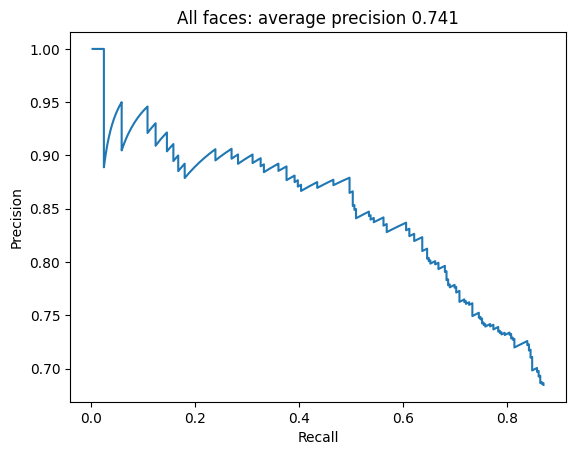

In [ ]:
solution_path = solution_path_root + "task1/"
ground_truth_path = ground_truth_path_root + "task1_gt_validare.txt"
verbose = True

evaluate_results_task1(solution_path, ground_truth_path, verbose)

(101, 4)
(101,)
(101,)


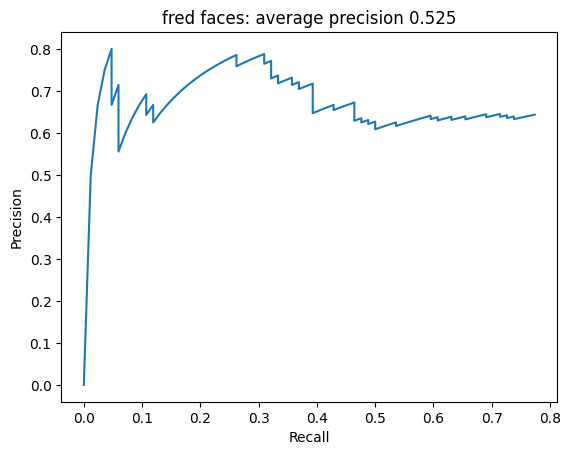

(71, 4)
(71,)
(71,)


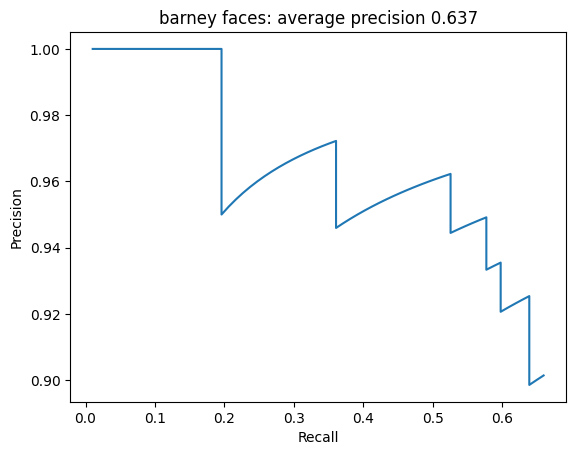

(50, 4)
(50,)
(50,)


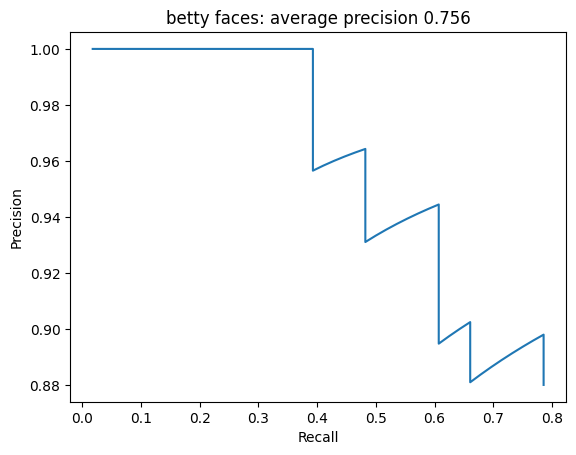

(73, 4)
(73,)
(73,)


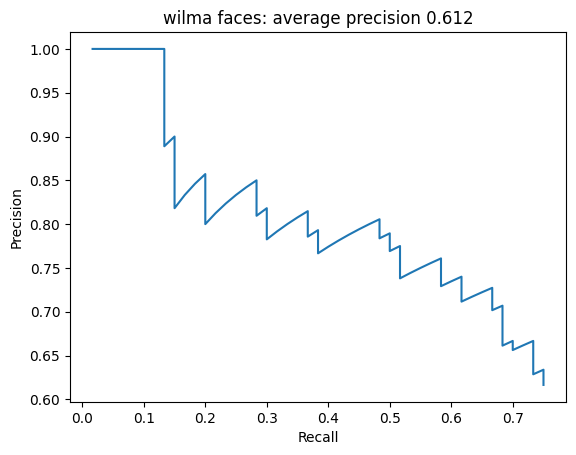

In [ ]:
solution_path = solution_path_root + "task2/"

ground_truth_path = ground_truth_path_root + "task2_fred_gt_validare.txt"
evaluate_results_task2(solution_path, ground_truth_path, "fred", verbose)

ground_truth_path = ground_truth_path_root + "task2_barney_gt_validare.txt"
evaluate_results_task2(solution_path, ground_truth_path, "barney", verbose)

ground_truth_path = ground_truth_path_root + "task2_betty_gt_validare.txt"
evaluate_results_task2(solution_path, ground_truth_path, "betty", verbose)

ground_truth_path = ground_truth_path_root + "task2_wilma_gt_validare.txt"
evaluate_results_task2(solution_path, ground_truth_path, "wilma", verbose)


#Evaluarea task-ului bonus

(341, 4)
(341,)
(341,)


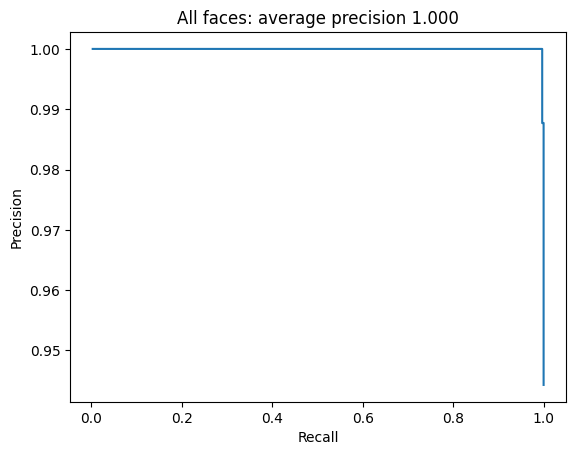

In [ ]:
solution_path = solution_path_root + "bonus/task1/"
ground_truth_path = ground_truth_path_root + "task1_gt_validare.txt"
verbose = True

evaluate_results_task1(solution_path, ground_truth_path, verbose)

(94, 4)
(94,)
(94,)


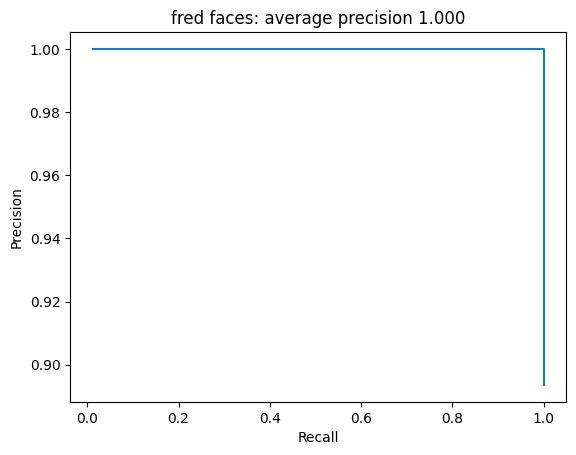

(100, 4)
(100,)
(100,)


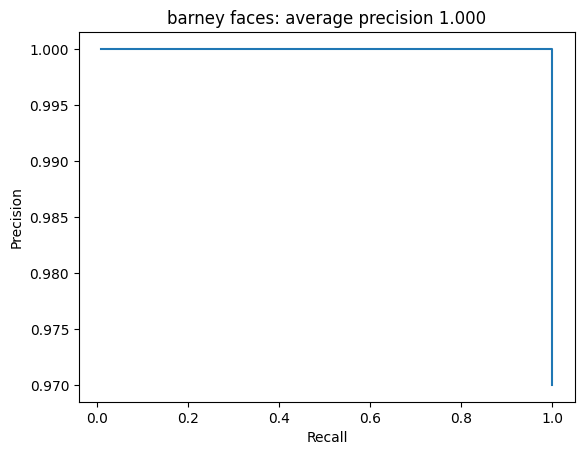

(56, 4)
(56,)
(56,)


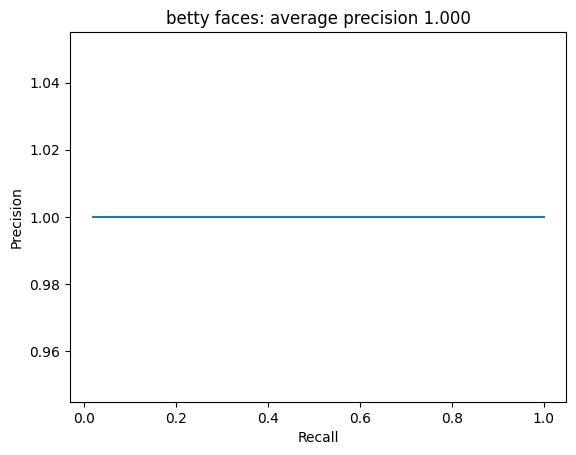

(62, 4)
(62,)
(62,)


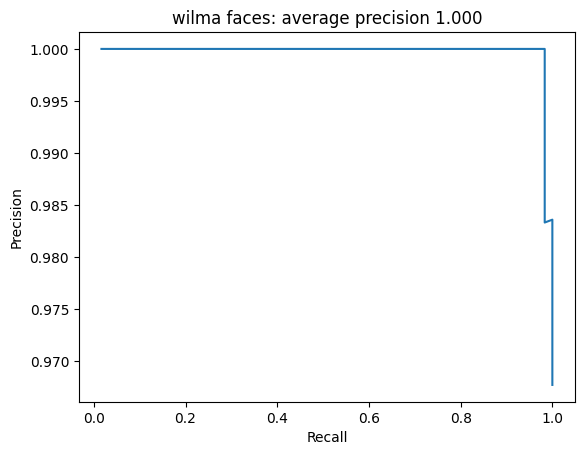

In [ ]:
solution_path = solution_path_root + "bonus/task2/"

ground_truth_path = ground_truth_path_root + "task2_fred_gt_validare.txt"
evaluate_results_task2(solution_path, ground_truth_path, "fred", verbose)

ground_truth_path = ground_truth_path_root + "task2_barney_gt_validare.txt"
evaluate_results_task2(solution_path, ground_truth_path, "barney", verbose)

ground_truth_path = ground_truth_path_root + "task2_betty_gt_validare.txt"
evaluate_results_task2(solution_path, ground_truth_path, "betty", verbose)

ground_truth_path = ground_truth_path_root + "task2_wilma_gt_validare.txt"
evaluate_results_task2(solution_path, ground_truth_path, "wilma", verbose)
